In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.linalg as linalg
import numpy as np
import scipy as scp

# Apply BFN on noisy linear systems

We will carry out the excersize on the following equation
The system is well described in, e.g., https://en.wikipedia.org/wiki/Lorenz_system

We will use the following parameter values:

$$
\sigma = 10 \,, \ \beta = ⁠8/3\,, \ \rho = 28 \,.
$$



In [3]:

def fx(x,y,z,t): return (sigma*(y-x))
def fy(x,y,z,t): return (x*(rho-z)-y)
def fz(x,y,z,t): return (x*y-beta*z)

def fx_neg(x,y,z,t): return -1*(sigma*(y-x))
def fy_neg(x,y,z,t): return -1*(x*(rho-z)-y)
def fz_neg(x,y,z,t): return -1*(x*y-beta*z)
#a) Defining the classical Runge-Kutta 4th order method

def RungeKutta4_forward(x,y,z,fx,fy,fz,t,h):
    k1x,k1y,k1z = ( h*f(x,y,z,t) for f in (fx,fy,fz) )
    # print( k1x,k1y,k1z)
    xs, ys,zs,ts = ( r+0.5*kr for r,kr in zip((x,y,z,t),(k1x,k1y,k1z,h)) )
    k2x,k2y,k2z = ( h*f(xs,ys,zs,ts) for f in (fx,fy,fz) )
    xs, ys,zs,ts = ( r+0.5*kr for r,kr in zip((x,y,z,t),(k2x,k2y,k2z,h)) )
    k3x,k3y,k3z = ( h*f(xs,ys,zs,ts) for f in (fx,fy,fz) )
    xs, ys,zs,ts = ( r+kr for r,kr in zip((x,y,z,t),(k3x,k3y,k3z,h)) )
    k4x,k4y,k4z  =( h*f(xs,ys,zs,ts) for f in (fx,fy,fz) )
    # print((r for r in (x,y,z)))
    return (r+(k1r+2*k2r+2*k3r+k4r)/6 for r,k1r,k2r,k3r,k4r in 
            zip((x,y,z),(k1x,k1y,k1z),(k2x,k2y,k2z),(k3x,k3y,k3z),(k4x,k4y,k4z)))

def RungeKutta4_backward(x,y,z,fx,fy,fz,t,h):
    k1x,k1y,k1z = ( h*f(x,y,z,t) for f in (fx,fy,fz) )
    # print( k1x,k1y,k1z)
    xs, ys,zs,ts = ( r+0.5*kr for r,kr in zip((x,y,z,t),(k1x,k1y,k1z,h)) )
    k2x,k2y,k2z = ( h*f(xs,ys,zs,ts) for f in (fx,fy,fz) )
    xs, ys,zs,ts = ( r+0.5*kr for r,kr in zip((x,y,z,t),(k2x,k2y,k2z,h)) )
    k3x,k3y,k3z = ( h*f(xs,ys,zs,ts) for f in (fx,fy,fz) )
    xs, ys,zs,ts = ( r+kr for r,kr in zip((x,y,z,t),(k3x,k3y,k3z,h)) )
    k4x,k4y,k4z  =( h*f(xs,ys,zs,ts) for f in (fx,fy,fz) )
    # print((r for r in (x,y,z)))
    return (r-(k1r+2*k2r+2*k3r+k4r)/6 for r,k1r,k2r,k3r,k4r in 
            zip((x,y,z),(k1x,k1y,k1z),(k2x,k2y,k2z),(k3x,k3y,k3z),(k4x,k4y,k4z)))



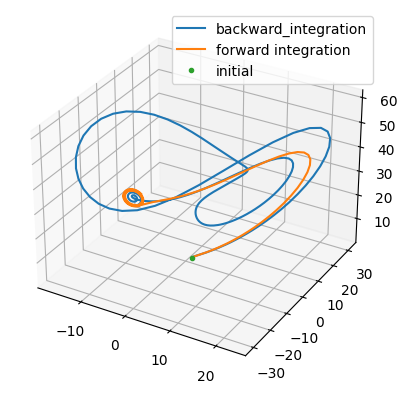

In [4]:
sigma=10.
beta=8./3.
rho=28.
tIn=3.
tFin=0.
h=-0.01
totalSteps=int(np.floor((tFin-tIn)/h))

t = totalSteps * [0.0]
x = totalSteps * [0.0]
y = totalSteps * [0.0]
z = totalSteps * [0.0]

x[0],y[0],z[0],t[0] = 1., 1., 1., 0.  #Initial condition
for i in range(1, totalSteps):
    x[i],y[i],z[i] = RungeKutta4_backward(x[i-1],y[i-1],z[i-1], fx_neg,fy_neg,fz_neg, t[i-1], -h)

ax = plt.figure().add_subplot(projection='3d')
ax.plot(x, y,z, "-", label="backward_integration")

tIn=0.
tFin=3.
h=0.01
totalSteps=int(np.floor((tFin-tIn)/h))
x[0],y[0],z[0],t[0] = 1., 1., 1., 0.  #Initial condition
for i in range(1, totalSteps):
    x[i],y[i],z[i] = RungeKutta4_forward(x[i-1],y[i-1],z[i-1], fx,fy,fz, t[i-1], h)

# ax = plt.figure().add_subplot(projection='3d')
ax.plot(x, y,z, "-", label="forward integration")
ax.plot([1.],[1.],[1.],".",label="initial")
plt.legend()

In [5]:
def generate_true(xin, tin, pars):
  x = tin * [0.0]
  y = tin * [0.0]
  z = tin * [0.0]
  beta,sigma,rho = pars
  x[0],y[0],z[0],t[0] = xin[0], xin[1], xin[2], tin[0]  #Initial condition
  for i in range(1, len(tin)):
    dt= tin[i]- tin[i-1]
    x[i],y[i],z[i] = RungeKutta4_forward(x[i-1],y[i-1],z[i-1], fx,fy,fz, t[i-1], dt)
      
  list_of_vec= [[x[i], y[i], z[i]] for i in range(len(t))]
  return np.array(list_of_vec)
  

def nudge_forward(xin, time, pars, K, y_obs, H):

  store_vec= []
  # a, b, d, g = pars
  # x, y = xin
  vec= xin
  for t in range(1, len(time)):
    store_vec.append(vec)
    
    dt= time[t]-time[t-1]
    x,y,z= RungeKutta4_forward(vec[0],vec[1],vec[2], fx,fy,fz, time[t-1], dt)
    vec_new= np.array([x,y,z])
    gain_vec= K*H.T@R_inv@(y_obs[t].T- H@vec_new.T)

    gain_vec_dt= np.array(dt*gain_vec)[0]
    # print(dt*dvec)
    vec= vec_new + gain_vec_dt
    
  store_vec.append(vec)

  return np.array(store_vec)

def nudge_backward(x_tilda, time, pars, K_prime, y_obs, H):

  store_vec= []
  vec= x_tilda.copy()
  
  for t in range(len(time)-1, 0, -1):
    store_vec.append(vec)
    
    dt= (-time[t]+time[t-1])

    x,y,z= RungeKutta4_backward(vec[0],vec[1],vec[2], fx_neg,fy_neg,fz_neg, time[i-1], -dt)
    
    vec_new= np.array([x,y,z])
    gain_vec= K_prime*H.T@R_inv@(y_obs[t].T- H@vec_new.T)
    gain_vec_dt= np.array(dt*gain_vec)[0]
    # print(dt*dvec)
    vec= vec_new - gain_vec_dt
    
  store_vec.append(vec)

  return np.flip(store_vec, axis=0)


def back_forth_nudge(pars, t, K, K_back, H, y_obs, number_of_iterations): #once
  store_backward, store_forward=[], []
  #tilta, normal
  xin= np.mean(y_obs, axis=0)
  nudge= nudge_forward(xin, t, pars, K, y_obs, H)
  store_forward.append(nudge)
  for it in range(number_of_iterations):
    nudge_back= nudge_backward(nudge[-1], t, pars, K_back, y_obs, H)
    nudge= nudge_forward(nudge_back[0], t, pars, K, y_obs, H)
    store_backward.append(nudge_back)
    store_forward.append(nudge)
  return store_forward, store_backward

In [6]:
def rmse(x, y):
    return np.sqrt(np.mean(np.square(x-y)))

def given_true_traj_rmse(xtraj, xtrue):
    
    rmse_x=rmse(xtraj[:,0], xtrue[:,0])
    rmse_y=rmse(xtraj[:,1], xtrue[:,1])
    rmse_z=rmse(xtraj[:,2], xtrue[:,2])
    
    rmse_v= np.array([rmse_x, rmse_y, rmse_z])
    return rmse_v

def given_true_traj_rmse_t(xtraj, xtrue):
    rmse_t=[]
    for i in range(len(xtraj)):
        rmse_v= rmse(xtraj, xtrue)
        rmse_t.append(rmse_v)
    return rmse_t

Generating the y_obs based on a fixed covariance matrix and observational operator.

Model parameters,
$$R=\begin{bmatrix}
1 &  1 & 0\\
1& 2 & 0\\
0& 0 & 2\\
\end{bmatrix}, H=\begin{bmatrix}
1 &  0 & 0\\
0& 1 & 0\\
0& 0 & 1\\
\end{bmatrix}$$

In [7]:
cov_obs= np.array([[1.,1.,0.],
                   [1.,2.,0.],
                   [0.,0., 2.]])
R_inv= np.eye(3)#np.linalg.inv(cov_obs)

t = np.linspace(0,6,10000)
xin= np.array([1,1,1])
beta = 8.0/3;  sigma = 10.0;  rho = 28.0;
pars = (beta,sigma,rho)
H= np.eye(3)

r = 1

xtrue= generate_true(xin, t, pars)
y_obs= xtrue*0.0
for i in range(len(t)):
    y_obs[i] = H.dot(xtrue[i]) + 2*np.random.multivariate_normal(mean= [0,0,0], cov= cov_obs)


For now, we take k=50.0, k'=100.0.

We have chosen our forward and backward gain matrices, as given in the paper,

$$K=kH^{T}, K'=k'H^{T}$$

In [8]:
# setting R_inv to identity, explained later
R_inv= np.eye(3)#np.linalg.inv(cov_obs)

K, K_back= 50,100

store_for, store_back=  back_forth_nudge(pars, t, K, K_back, H, y_obs, 20)

In [9]:
x_nonudge= generate_true(y_obs[0], t, pars)

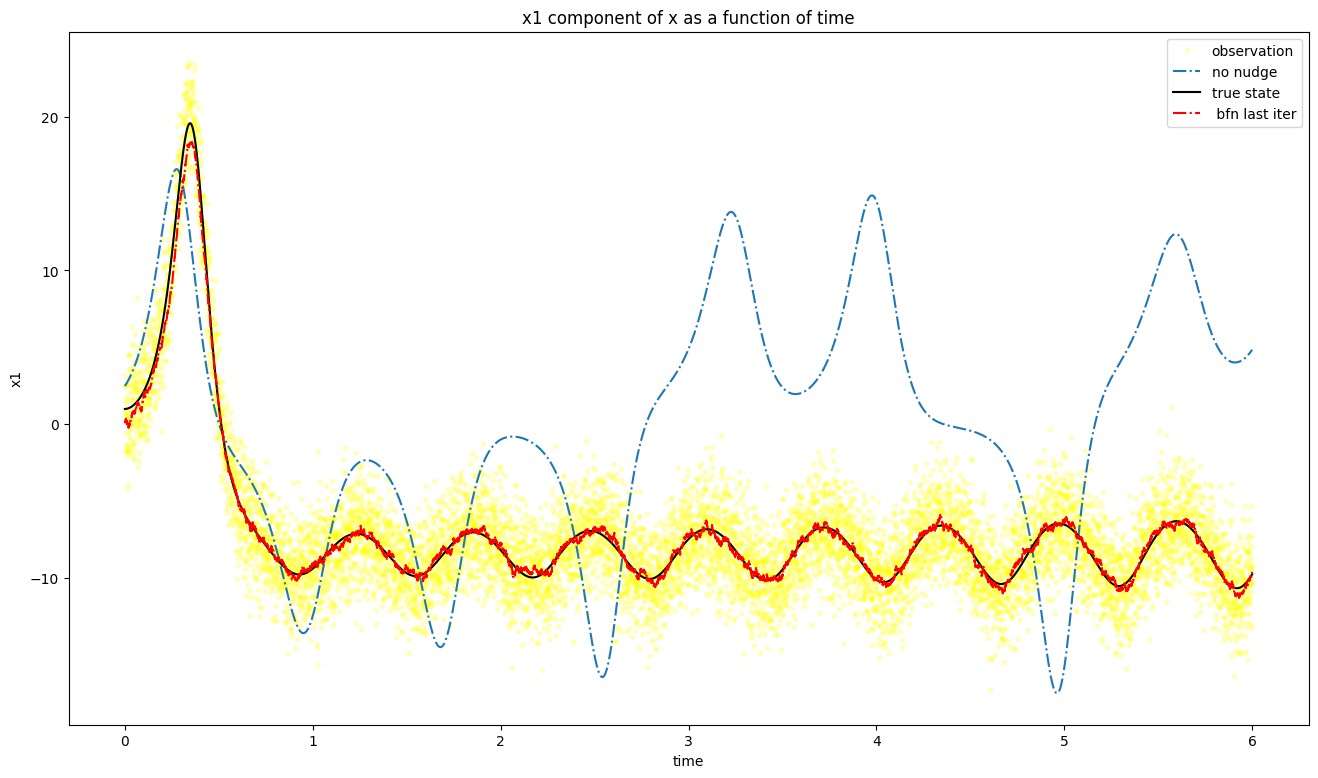

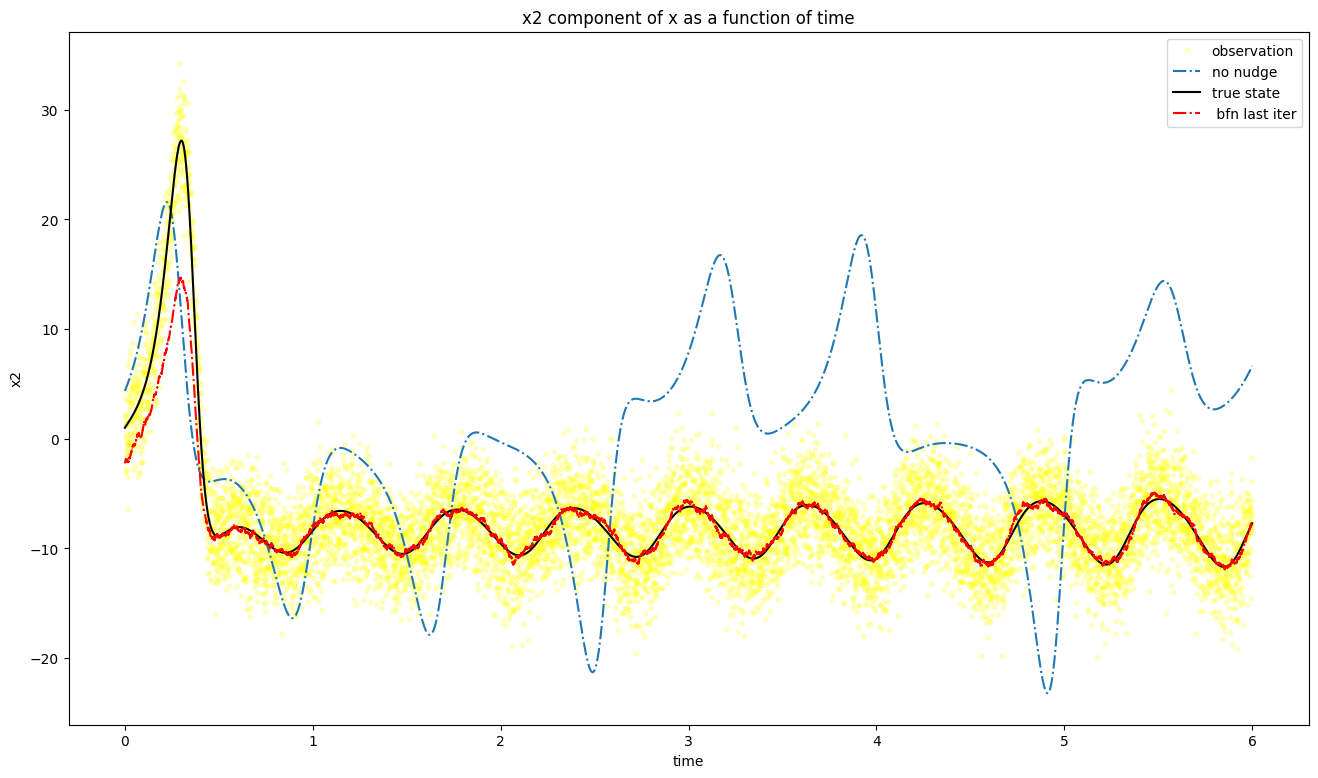

Text(0, 0.5, 'x3')

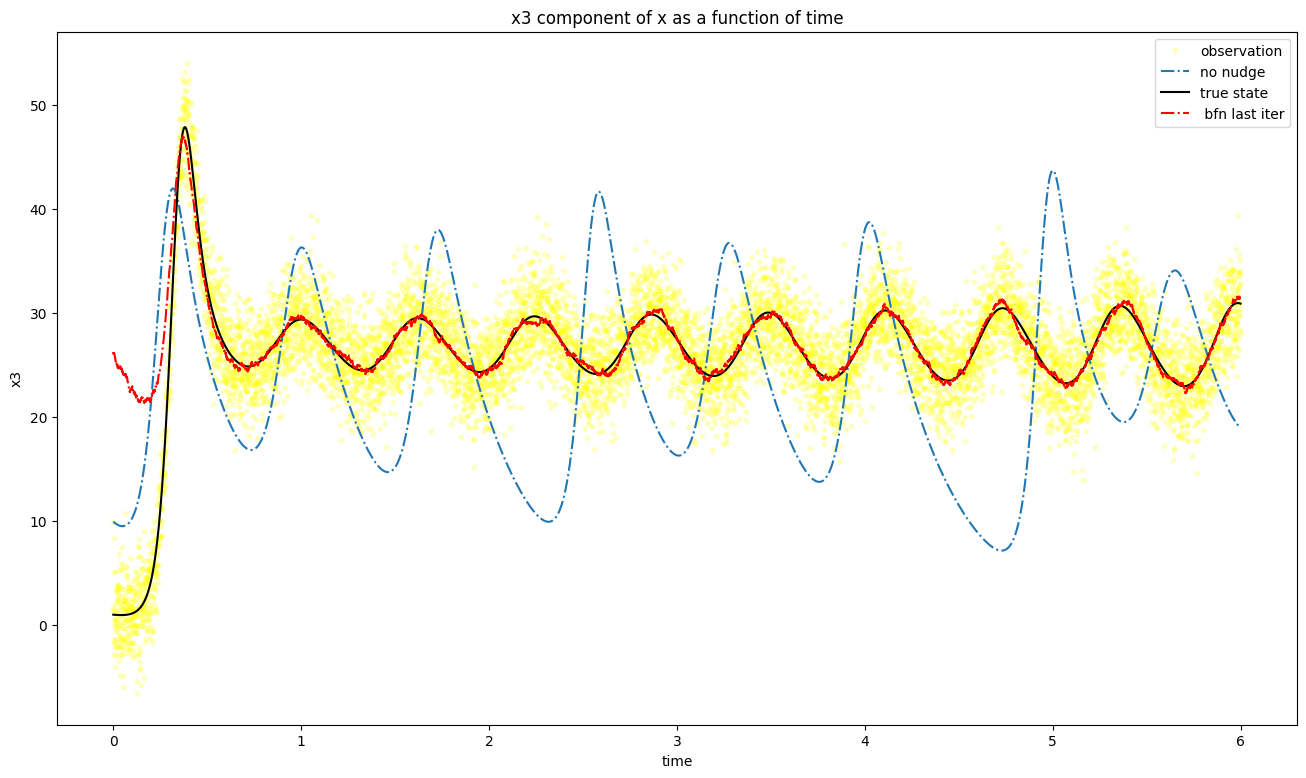

In [10]:
plt.figure(figsize= (16,9))
it= 0
plt.plot(t, y_obs[:,it], ".", alpha=0.2, label="observation", color="yellow")
plt.plot(t, x_nonudge[:,it], "-.", label= "no nudge")

plt.plot(t, xtrue[:,it], label= "true state", color= "black")
plt.plot(t, store_for[-1][:,it], "-.", label=" bfn last iter", color= "red")
# plt.plot(t, store_back[-1][:,0], "-.")
plt.legend()
plt.title(f"x{it+1} component of x as a function of time")
plt.xlabel("time"); plt.ylabel(f"x{it+1}")
plt.show()

plt.figure(figsize= (16,9))
it= 1
plt.plot(t, y_obs[:,it], ".", alpha=0.2, label="observation", color="yellow")
plt.plot(t, x_nonudge[:,it], "-.", label= "no nudge")

plt.plot(t, xtrue[:,it], label= "true state", color= "black")
plt.plot(t, store_for[-1][:,it], "-.", label=" bfn last iter", color="red")
# plt.plot(t, store_back[-1][:,0], "-.")
plt.legend()
plt.title(f"x{it+1} component of x as a function of time")
plt.xlabel("time"); plt.ylabel(f"x{it+1}")
plt.show()

plt.figure(figsize= (16,9))
it= 2
plt.plot(t, y_obs[:,it], ".", alpha=0.2, label="observation", color="yellow")
plt.plot(t, x_nonudge[:,it], "-.", label= "no nudge")

plt.plot(t, xtrue[:,it], label= "true state", color= "black")
plt.plot(t, store_for[-1][:,it], "-.", label=" bfn last iter", color="r")
# plt.plot(t, store_back[-1][:,0], "-.")
plt.legend()
plt.title(f"x{it+1} component of x as a function of time")
plt.xlabel("time"); plt.ylabel(f"x{it+1}")


Text(0, 0.5, 'rmse')

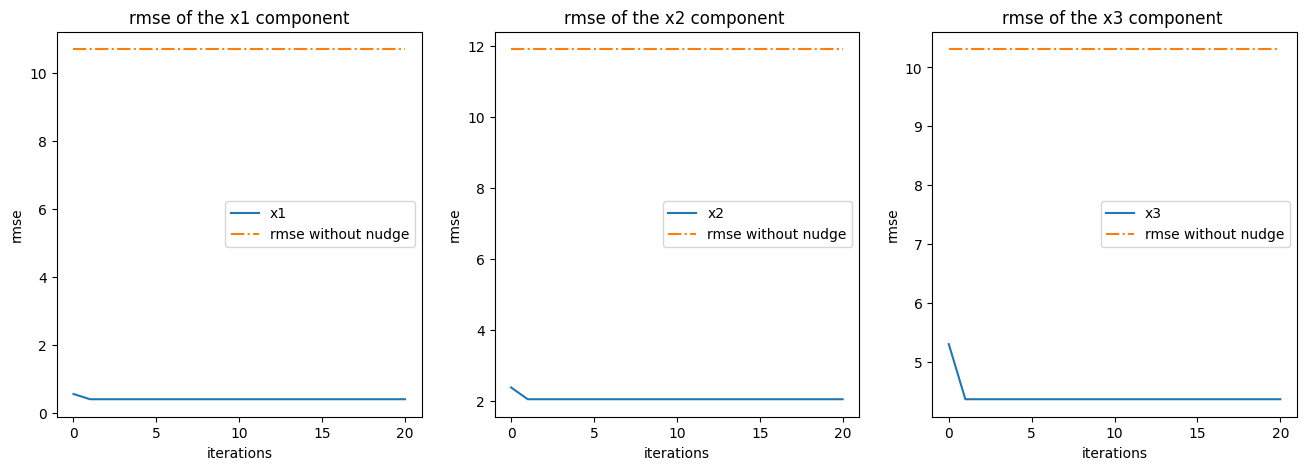

In [11]:
rmse_iter= np.array([given_true_traj_rmse(traj[:], xtrue[:]) for traj in store_for])
rmse_no_nudge= np.array([given_true_traj_rmse(x_nonudge[:], xtrue[:])] * len(rmse_iter))

plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.plot(rmse_iter[:,0], label="x1")
plt.plot(rmse_no_nudge[:,0], "-.",label="rmse without nudge")
plt.legend()
plt.title("rmse of the x1 component")
plt.xlabel("iterations")
plt.ylabel("rmse")
# plt.show()
plt.subplot(1,3,2)
plt.plot(rmse_iter[:,1], label="x2")
plt.plot(rmse_no_nudge[:,1], "-.",label="rmse without nudge")
plt.legend()
plt.title("rmse of the x2 component ")
plt.xlabel("iterations")
plt.ylabel("rmse")

plt.subplot(1,3,3)
plt.plot(rmse_iter[:,2], label="x3")
plt.plot(rmse_no_nudge[:,2], "-.",label="rmse without nudge")
plt.legend()
plt.title("rmse of the x3 component ")
plt.xlabel("iterations")
plt.ylabel("rmse")

BFN coverges and gives much lower rmse than null

# Effect of very large K and K'

For now, we take k=500.0, k'=500.0.

We have chosen our forward and backward gain matrices, as given in the paper,

$$K=kH^{T}, K'=k'H^{T}$$

In [12]:
# setting R_inv to identity, explained later
R_inv= np.eye(3)#np.linalg.inv(cov_obs)

K, K_back= 500,500

store_for, store_back=  back_forth_nudge(pars, t, K, K_back, H, y_obs, 20)

In [13]:
x_nonudge= generate_true(y_obs[0], t, pars)

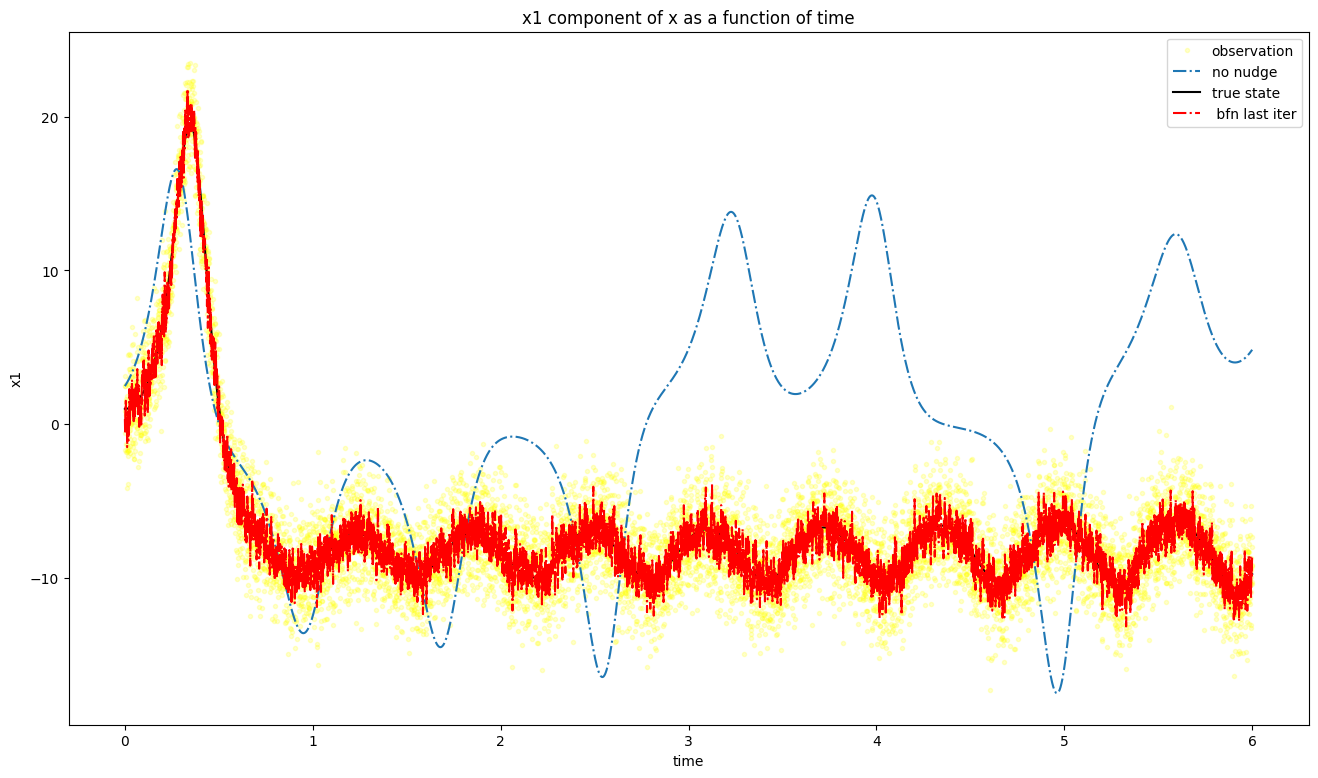

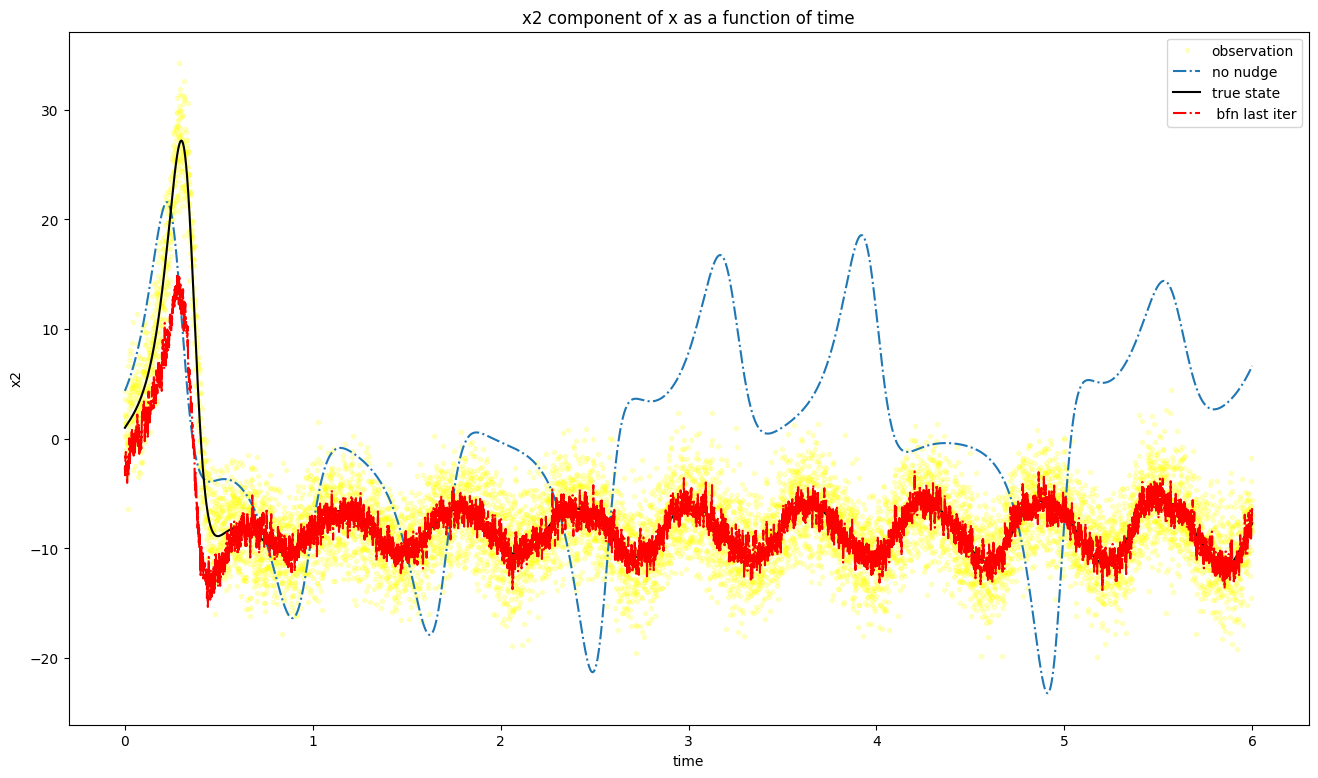

Text(0, 0.5, 'x3')

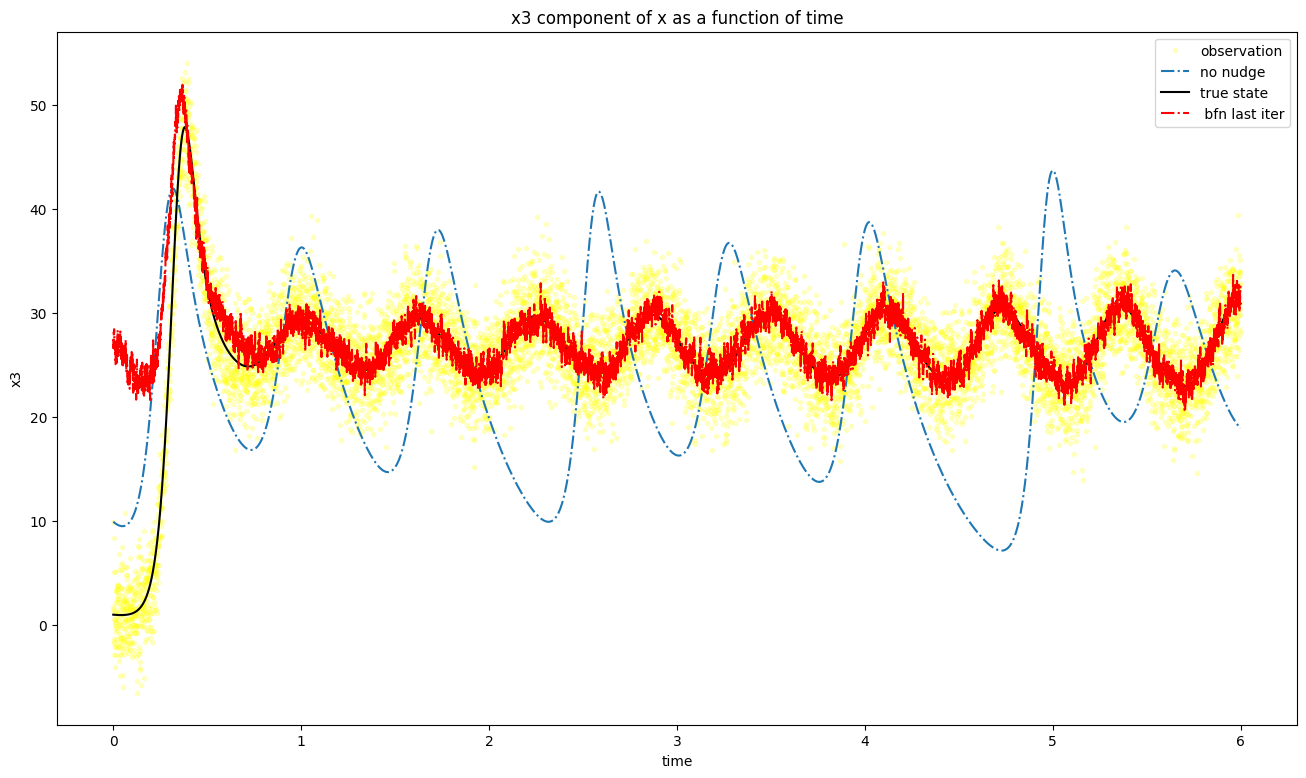

In [14]:
plt.figure(figsize= (16,9))
it= 0
plt.plot(t, y_obs[:,it], ".", alpha=0.2, label="observation", color="yellow")
plt.plot(t, x_nonudge[:,it], "-.", label= "no nudge")

plt.plot(t, xtrue[:,it], label= "true state", color= "black")
plt.plot(t, store_for[-1][:,it], "-.", label=" bfn last iter", color= "red")
# plt.plot(t, store_back[-1][:,0], "-.")
plt.legend()
plt.title(f"x{it+1} component of x as a function of time")
plt.xlabel("time"); plt.ylabel(f"x{it+1}")
plt.show()

plt.figure(figsize= (16,9))
it= 1
plt.plot(t, y_obs[:,it], ".", alpha=0.2, label="observation", color="yellow")
plt.plot(t, x_nonudge[:,it], "-.", label= "no nudge")

plt.plot(t, xtrue[:,it], label= "true state", color= "black")
plt.plot(t, store_for[-1][:,it], "-.", label=" bfn last iter", color="red")
# plt.plot(t, store_back[-1][:,0], "-.")
plt.legend()
plt.title(f"x{it+1} component of x as a function of time")
plt.xlabel("time"); plt.ylabel(f"x{it+1}")
plt.show()

plt.figure(figsize= (16,9))
it= 2
plt.plot(t, y_obs[:,it], ".", alpha=0.2, label="observation", color="yellow")
plt.plot(t, x_nonudge[:,it], "-.", label= "no nudge")

plt.plot(t, xtrue[:,it], label= "true state", color= "black")
plt.plot(t, store_for[-1][:,it], "-.", label=" bfn last iter", color="r")
# plt.plot(t, store_back[-1][:,0], "-.")
plt.legend()
plt.title(f"x{it+1} component of x as a function of time")
plt.xlabel("time"); plt.ylabel(f"x{it+1}")


Text(0, 0.5, 'rmse')

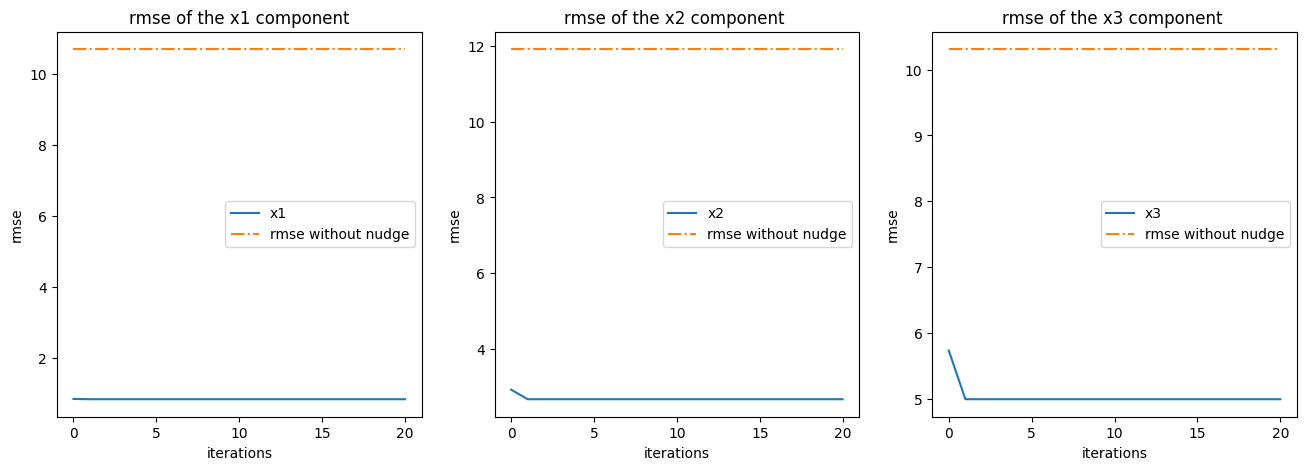

In [15]:
rmse_iter= np.array([given_true_traj_rmse(traj[:], xtrue[:]) for traj in store_for])
rmse_no_nudge= np.array([given_true_traj_rmse(x_nonudge[:], xtrue[:])] * len(rmse_iter))

plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.plot(rmse_iter[:,0], label="x1")
plt.plot(rmse_no_nudge[:,0], "-.",label="rmse without nudge")
plt.legend()
plt.title("rmse of the x1 component")
plt.xlabel("iterations")
plt.ylabel("rmse")
# plt.show()
plt.subplot(1,3,2)
plt.plot(rmse_iter[:,1], label="x2")
plt.plot(rmse_no_nudge[:,1], "-.",label="rmse without nudge")
plt.legend()
plt.title("rmse of the x2 component ")
plt.xlabel("iterations")
plt.ylabel("rmse")

plt.subplot(1,3,3)
plt.plot(rmse_iter[:,2], label="x3")
plt.plot(rmse_no_nudge[:,2], "-.",label="rmse without nudge")
plt.legend()
plt.title("rmse of the x3 component ")
plt.xlabel("iterations")
plt.ylabel("rmse")

Larger k and k', lead to more "influence" of observations on your final output. This is why the final output is noisier and more spread out when k,k' are increased. 

BFN still coverges at low rmse but the output is just more "noiser".